# OSMnx network generation

Author: [Geoff Boeing](https://geoffboeing.com/)

Adjusted for Velobserver use: [Djordje Rakonjac](https://rs.linkedin.com/in/djordje-rakonjac)

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  
For Velobserver network use, change geoloation to match desired city.

In [1]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.0.1'

## Working with street networks

In [2]:
bidirectional_network_types=['all']

In [3]:
ox.settings.bidirectional_network_types=['all']

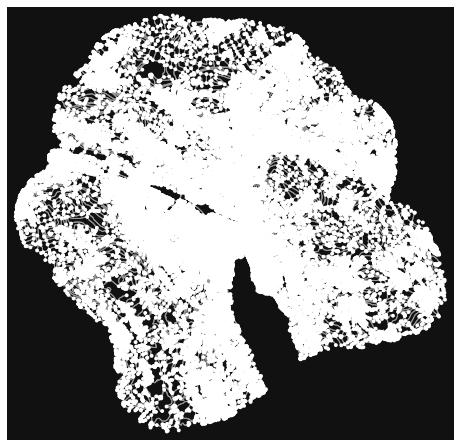

In [4]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place('Zurich, Switzerland', network_type='all', buffer_dist = 2000.0)
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Zurich Switzerland" to retrieve the place boundaries of that city from the Nominatim API, retrieves the street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

In [5]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.get_digraph(G)

In [6]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
#ox.save_graph_geopackage(G, filepath='./data/zurich_all.gpkg', )

ox.save_graph_geopackage(M, filepath='./data/zurich_all.gpkg', )

#ox.save_graphml(G, filepath='./data/zurich_all.graphml')
#ox.save_graph_shapefile(G, filepath='./data/zurich_all.shp', encoding='utf-8', directed=False)

In [4]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,ref,highway,street_count,geometry
osmid,,,,,,
453763,47.397642,8.477263,2,motorway_junction,3,POINT (8.47726 47.39764)
453768,47.395319,8.484325,NaN,NaN,3,POINT (8.48433 47.39532)
453805,47.385077,8.508399,NaN,NaN,4,POINT (8.50840 47.38508)
453810,47.383217,8.506074,NaN,NaN,4,POINT (8.50607 47.38322)
453814,47.381908,8.509203,NaN,NaN,3,POINT (8.50920 47.38191)


In [5]:
gdf_edges.head()

osmid  \
u      v          key                                                      
453763 71321619   0                                             16076655   
       453768     0                                [383751586, 16076659]   
453768 161611877  0    [9386989, 284193360, 438520592, 134223699, 438...   
453805 1830082753 0                                              5880393   
       1830082755 0                                             23167518   

                       oneway   lanes              highway   maxspeed  \
u      v          key                                                   
453763 71321619   0      True       1        motorway_link         80   
       453768     0      True  [2, 3]             motorway  [100, 80]   
453768 161611877  0      True  [2, 3]  [primary, motorway]   [80, 60]   
453805 1830082753 0      True     NaN             tertiary         50   
       1830082755 0     False     NaN             tertiary         50   

                        length  \
u      v          key            
453763 71321619   0    257.806   
       453768     0    592.270   
453768 161611877  0    830.352   
453805 1830082753 0     11.402   
       1830082755 0     10.984   

                                                                geometry  ref  \
u      v          key                                                           
453763 71321619   0    LINESTRING (8.47726 47.39764, 8.47787 47.39726...  NaN   
       453768     0    LINESTRING (8.47726 47.39764, 8.47794 47.39735...  A1H   
453768 161611877  0    LINESTRING (8.48433 47.39532, 8.48799 47.39442...  A1H   
453805 1830082753 0      LINESTRING (8.50840 47.38508, 8.50831 47.38500)  NaN   
       1830082755 0      LINESTRING (8.50840 47.38508, 8.50853 47.38504)  NaN   

                                 name service tunnel bridge access width  \
u      v          key                                                      
453763 71321619   0               NaN     NaN    NaN    NaN    NaN   NaN   
       453768     0               NaN     NaN    NaN    NaN    NaN   NaN   
453768 161611877  0               NaN     NaN    NaN    NaN    NaN   NaN   
453805 1830082753 0    Herdernstrasse     NaN    NaN    NaN    NaN   NaN   
       1830082755 0       Hohlstrasse     NaN    NaN    NaN    NaN   NaN   

                      junction area est_width  
u      v          key                          
453763 71321619   0        NaN  NaN       NaN  
       453768     0        NaN  NaN       NaN  
453768 161611877  0        NaN  NaN       NaN  
453805 1830082753 0        NaN  NaN       NaN  
       1830082755 0        NaN  NaN       NaN

You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge shapefiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [6]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

## Basic street network stats

In [7]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

109334437.91573559

In [8]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 15681,
 'm': 36460,
 'k_avg': 4.650213634334545,
 'intersection_count': 11679,
 'streets_per_node_avg': 2.6205599132708373,
 'streets_per_node_counts': {0: 0,
  1: 4002,
  2: 265,
  3: 9367,
  4: 1833,
  5: 168,
  6: 36,
  7: 8,
  8: 2},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.25521331547732923,
  2: 0.016899432434155984,
  3: 0.5973471079650533,
  4: 0.1168930552898412,
  5: 0.010713602448823417,
  6: 0.0022957719533193035,
  7: 0.0005101715451820675,
  8: 0.00012754288629551687},
 'edge_length_total': 2662155.40299999,
 'edge_length_avg': 73.01578176083352,
 'street_length_total': 1474825.6040000054,
 'street_length_avg': 72.0868861625693,
 'street_segments_count': 20459,
 'node_density_km': 143.42233150807797,
 'intersection_density_km': 106.81904277041278,
 'edge_density_km': 24348.736351960048,
 'street_density_km': 13489.122294081379,
 'circuity_avg': 1.0599729448304585,
 'self_loop_proportion': 0.0024410312671420734,
 'clean_intersection_count': 6800,
 'clean_inter

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [ ]:
# see more stats (mostly topological stuff) with extended_stats
more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True) #use arguments to turn other toplogical analyses on/off
for key in sorted(more_stats.keys()):
    print(key)

In [ ]:
more_stats['radius']

The radius (i.e., minimum eccentricity) of this street network.

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

In [17]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

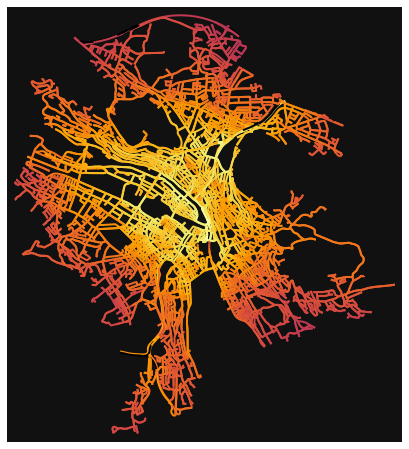

In [18]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

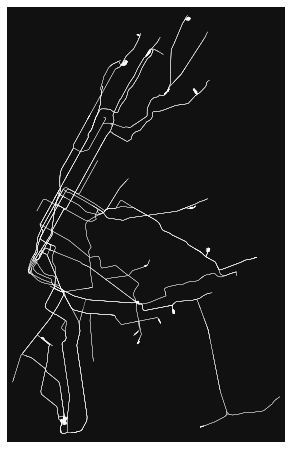

In [4]:
# get NY subway rail network
G = ox.graph_from_place('Zurich, Switzerland',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"~"train"]')

fig, ax = ox.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.2)